In [1]:
# import functions
import idaes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom
# parmest (binary_param2)
from binary_param2 import binary_params_peng

In [2]:
# from HFC32_emimTf2N_PR import configuration
from HFC32_bmimBF4_PR import configuration

In [3]:
#need to make excel csv for 125
data = pd.read_csv('R32_bmimBF4.csv')
# print(data)

In [13]:
# 283
data_283= data[(data.temperature > 282) & (data.temperature< 284)]

# 298
data_298 = data[(data.temperature > 297) & (data.temperature< 299)]
data_298 = data_298.reset_index(drop=True)

# 323
data_323 = data[(data.temperature > 322) & (data.temperature< 324)]
data_323 = data_323.reset_index(drop=True)

# 323
data_348 = data[(data.temperature > 347) & (data.temperature< 349)]
data_348 = data_348.reset_index(drop=True)

In [17]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

2021-03-30 15:35:54 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
The initial DOF is 7


In [18]:
def calc_outlet_xP(data,k21,k12,verbose=False):
    # create zeros arrays to be filled with x1 and P1
    R32_x = np.zeros((len(data)))
    P = np.zeros((len(data)))
    
    # model constraints
    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_bmimBF4"].iloc[i]
        m.fs.F101.inlet.flow_mol.fix(1) 
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.properties.PR_kappa['bmimBF4', 'R32'].fix(k21) # (-0.20093)
        m.fs.properties.PR_kappa['R32', 'bmimBF4'].fix(k12) # (-0.05619)

        if verbose:
            DOF_final = degrees_of_freedom(m)
            print("The final DOF is {0}".format(DOF_final))

        # solver
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        solver = SolverFactory('ipopt')
        solver.options = {'tol': 1e-6}
        status = solver.solve(m, tee = False)
    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible.')
    return(R32_x,P)

###### T = 283 K

In [19]:
# from HFC32_emimTf2N_PR import configuration
binary_params_peng(data_283,configuration, 'R32', 'bmimBF4', "x_R32", "x_bmimBF4", 
    init_temp = 283.2, init_press = 399500, init_x_c1 = 0.374 , init_x_c2 = 0.626 ,
    init_kappa_2_1 = -0.019, init_kappa_1_2 =  0.0056, eps = 0.1, scaling_fac = 1e-9, read=False)

2021-03-30 15:36:09 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:36:10 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:36:10 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:36:10 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:36:10 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:36:10 [INFO] idaes.init.fs.state_

In [20]:
k12_283 = 0.005625974168616829
k21_283 = -0.01895073670861511

In [21]:
R32_x,P= calc_outlet_xP(data,k21_283,k12_283, verbose=True)

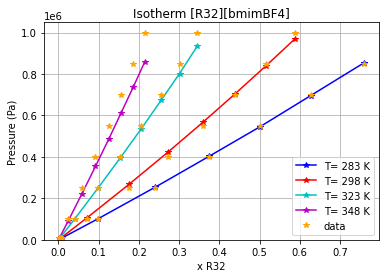

In [22]:
# plots with data - model as lines --- need to make this into a function that splits up the T's
plt.plot(R32_x[0:7],P[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:],P[23:],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"],"*",color='orange',label="data")  
plt.title('Isotherm [R32][bmimBF4]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,)
plt.legend()
plt.show()

### T = 298 K

In [23]:
# from HFC32_emimTf2N_PR import configuration
binary_params_peng(data_298, configuration, 'R32', 'bmimBF4', "x_R32", "x_bmimBF4", 
    init_temp = 298, init_press = 399900, init_x_c1 = 0.272 , init_x_c2 = 0.728 ,
    init_kappa_2_1 = 0.097, init_kappa_1_2 =  0.02, eps = 0.1, scaling_fac = 1e-9, read=False)

2021-03-30 15:37:25 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:37:25 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:37:25 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:37:25 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:37:25 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:37:25 [INFO] idaes.init.fs.state_

In [24]:
k12_298 = -0.006368701203852821
k21_298 = -0.13572948246274677

In [27]:
R32_x,P= calc_outlet_xP(data,k21_298,k12_298, verbose=False)

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


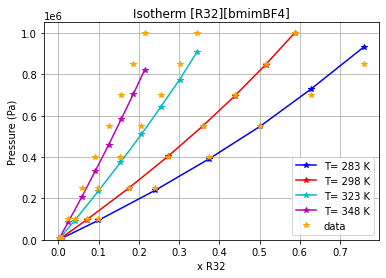

In [28]:
# plots with data - model as lines --- need to make this into a function that splits up the T's
plt.plot(R32_x[0:7],P[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:],P[23:],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"],"*",color='orange',label="data")  
plt.title('Isotherm [R32][bmimBF4]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,)
plt.legend()
plt.show()

### T= 323 K

In [35]:
# from HFC32_emimTf2N_PR import configuration
binary_params_peng(data_323, configuration, 'R32', 'bmimBF4', "x_R32", "x_bmimBF4", 
    init_temp = 323.2, init_press = 399600, init_x_c1 = 0.154 , init_x_c2 = 0.846 ,
    init_kappa_2_1 = 0.097, init_kappa_1_2 =  0.02, eps = 0.1, scaling_fac = 1e-9, read=False)

2021-03-30 15:43:44 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:43:45 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:43:45 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:43:45 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:43:45 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:43:45 [INFO] idaes.init.fs.state_

In [36]:
k12_323 = 0.0017676532608226227
k21_323 = -0.2570282763493638

In [37]:
R32_x,P= calc_outlet_xP(data,k21_323,k12_323, verbose=False)

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


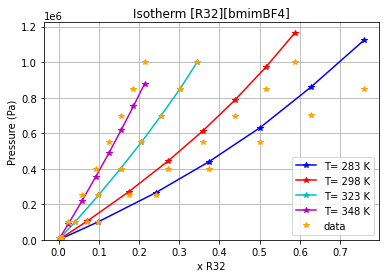

In [38]:
# plots with data - model as lines --- need to make this into a function that splits up the T's
plt.plot(R32_x[0:7],P[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:],P[23:],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"],"*",color='orange',label="data")  
plt.title('Isotherm [R32][bmimBF4]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,)
plt.legend()
plt.show()

### T= 348 K

In [39]:
print(data_348)

   temperature  pressure  x_R32  x_bmimBF4
0        348.2      9700  0.002      0.998
1        348.1     99600  0.024      0.976
2        348.1    249500  0.058      0.942
3        348.2    399500  0.092      0.908
4        348.1    549500  0.125      0.875
5        348.2    699600  0.156      0.844
6        348.1    849600  0.186      0.814
7        348.1    999900  0.214      0.786


In [40]:
# from HFC32_emimTf2N_PR import configuration
binary_params_peng(data_348, configuration, 'R32', 'bmimBF4', "x_R32", "x_bmimBF4", 
    init_temp = 348.1, init_press = 549500, init_x_c1 = 0.125, init_x_c2 = 0.875,
    init_kappa_2_1 = 0.097, init_kappa_1_2 =  0.02, eps = 0.1, scaling_fac = 1e-9, read=False)

2021-03-30 15:46:38 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:46:38 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:46:38 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:46:39 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 15:46:39 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 15:46:39 [INFO] idaes.init.fs.state_

In [41]:
k12_348 = 0.022367544160091395
k21_348 = -0.32538626875645615

In [42]:
R32_x,P= calc_outlet_xP(data,k21_348,k12_348, verbose=False)

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.


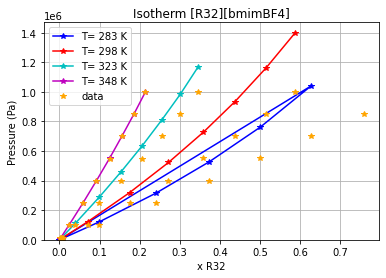

In [43]:
# plots with data - model as lines --- need to make this into a function that splits up the T's
plt.plot(R32_x[0:7],P[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:],P[23:],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"],"*",color='orange',label="data")  
plt.title('Isotherm [R32][bmimBF4]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,)
plt.legend()
plt.show()